In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
np.random.seed(42)

import tensorflow as tf
tf.random.set_seed(42)

import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

#from utils import confusion_matrix



In [4]:
csv_filename = '/content/drive/MyDrive/motionProject/2023-02-22_6axis_data.csv'
df = pd.read_csv(csv_filename, encoding='utf8', low_memory=False) # utf8, cp949 |
df.shape


(12264, 8)

In [5]:
display(df.head())

display(df.tail())

,dataId,label,accX,accY,accZ,gyroX,gyroY,gyroZ
0,1,sit,-8.7147,-1.1294,4.6516,18.5346,-10.9834,-22.6534
1,1,sit,-8.7386,-1.1773,4.6564,18.5346,-8.2376,-21.2804
2,1,sit,-8.7338,-1.1486,4.6708,10.9834,1.3729,-26.0857
3,1,sit,-8.7003,-1.1246,4.7234,-4.8053,18.5346,-34.3233
4,1,sit,-8.6381,-1.0720,4.7186,-16.4752,48.0526,-42.5609


,dataId,label,accX,accY,accZ,gyroX,gyroY,gyroZ
12259,180,sit,-9.6622,-0.2058,-0.2489,22.6534,159.9465,190.1509
12260,180,sit,-9.6096,0.0479,-0.4834,-57.6631,132.4878,199.0750
12261,180,sit,-9.8154,0.3398,-0.6700,-96.1052,139.3525,186.0322
12262,180,sit,-10.0451,0.5360,-0.8279,-113.2668,154.4547,151.0224
12263,180,sit,-10.1408,0.5934,-0.8853,-100.2240,179.8540,124.9367


In [6]:
train = df[['accX','accY','accZ','gyroX','gyroY','gyroZ']]

In [7]:
test = df['label']

In [8]:
test.unique()

array(['sit', 'fallforward', 'idle', 'walk', 'standup'], dtype=object)

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train, test, test_size=0.33, random_state=42)
# train-test data split
# X는 input, Y는 (정답)output

In [10]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8216, 6), (4048, 6), (8216,), (4048,))

In [11]:
epochs = 30
batch_size = 16
n_hidden = 32

In [12]:
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [13]:
# To reshape the data, convert the DataFrames to NumPy arrays first and then perform the reshape operation.

X_train = X_train.values
X_test = X_test.values

In [14]:
X_train

array([[-8.700300e+00, -3.201600e+00,  3.670600e+00,  1.674976e+02,
        -1.784810e+01, -1.009104e+02],
       [-9.351200e+00, -6.126000e-01,  4.331000e+00,  8.718110e+01,
         1.146397e+02, -1.249367e+02],
       [-1.325150e+01,  1.383100e+00,  3.254200e+00, -5.491700e+00,
        -7.551120e+01, -1.832863e+02],
       ...,
       [-9.054400e+00,  3.830000e-02,  4.149200e+00,  2.745900e+00,
        -1.510220e+01, -1.098340e+01],
       [-9.202800e+00,  7.513000e-01,  2.837900e+00,  6.864700e+00,
        -1.304285e+02, -1.784810e+01],
       [-9.619100e+00, -2.785200e+00,  4.364500e+00,  1.263097e+02,
        -1.441578e+02,  4.873900e+01]])

In [15]:
y_train = y_train.values
y_test = y_test.values

In [16]:
# reshape input to be 3D [samples, timesteps, features]
# https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [17]:
X_train.shape

(8216, 1, 6)

In [18]:
X_test.shape

(4048, 1, 6)

In [19]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(8216, 1, 6) (8216,) (4048, 1, 6) (4048,)


In [20]:
# 분류하고 싶은 클래스 개수
n_classes = _count_classes(y_train) 
n_classes

5

In [21]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
# ['PC' 'TABLET' 'MOBILE'] ==> [1 2 0]

In [22]:
from keras.utils import to_categorical

# 원 핫 인코딩 
#    0 1 2
# 1  0 1 0
# 2  0 0 1
# 0  1 0 0

y_train = to_categorical(y_train, num_classes=n_classes)
y_test = to_categorical(y_test, num_classes=n_classes)

In [27]:
model = Sequential()

# n_hidden : 은닉계층에 임베딩되는 차원
# LSTM cell =  n_hidden 차원으로 만드는 것
# timestep : split해서 넣을 데이터 절편 크기
model.add(LSTM(n_hidden, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
# input차원 - (timesteps, input_dim)
model.add(Dropout(0.5))
model.add(LSTM(n_hidden))
model.add(Dropout(0.5))


model.add(Dense(n_classes, activation='softmax'))

# loss : predicted 결과와 real 결과의 차이
# optimizer : local optimum에 빠지지 않도록 넘어가게 해주는 장치, Adam 많이 씀
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))


Epoch 1/30
514/514 [==============================] - 10s 8ms/step - loss: 1.3888 - accuracy: 0.4304 - val_loss: 1.1883 - val_accuracy: 0.5462
Epoch 2/30
514/514 [==============================] - 3s 6ms/step - loss: 1.2421 - accuracy: 0.5097 - val_loss: 1.1099 - val_accuracy: 0.5697
Epoch 3/30
514/514 [==============================] - 5s 10ms/step - loss: 1.2014 - accuracy: 0.5308 - val_loss: 1.0784 - val_accuracy: 0.5776
Epoch 4/30
514/514 [==============================] - 3s 6ms/step - loss: 1.1697 - accuracy: 0.5534 - val_loss: 1.0487 - val_accuracy: 0.5961
Epoch 5/30
514/514 [==============================] - 3s 6ms/step - loss: 1.1448 - accuracy: 0.5662 - val_loss: 1.0206 - val_accuracy: 0.6208
Epoch 6/30
514/514 [==============================] - 3s 6ms/step - loss: 1.1270 - accuracy: 0.5645 - val_loss: 1.0030 - val_accuracy: 0.6262
Epoch 7/30
514/514 [==============================] - 5s 10ms/step - loss: 1.1143 - accuracy: 0.5835 - val_loss: 0.9815 - val_accuracy: 0.6383
Epo

In [28]:
from keras.models import load_model

model.save('/content/drive/MyDrive/motionProject/lstm_model.h5')
model.summary()

#from google.colab import files
#files.download('saved_model')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 1, 32)             4992      
                                                                 
 dropout_5 (Dropout)         (None, 1, 32)             0         
                                                                 
 lstm_8 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 5)                 165       
                                                                 
Total params: 13,477
Trainable params: 13,477
Non-trainable params: 0
_________________________________________________________________


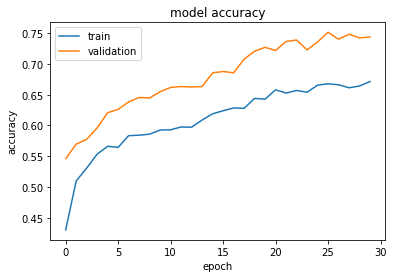

In [29]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [30]:
from sklearn.metrics import confusion_matrix

y_test_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(model.predict(X_test), axis=1)
print(confusion_matrix(y_test_classes, y_pred_classes))

127/127 [==============================] - 1s 2ms/step
[[ 208    0   15    9   58]
 [  13  632   26   52  245]
 [  13   37  338  126   45]
 [  27   30  102  427  130]
 [   1   48   19   41 1406]]


### 랜덤 인풋에 따른 예측결과

In [31]:
model_new = tf.keras.models.load_model("/content/drive/MyDrive/motionProject/lstm_model.h5")

In [32]:
test_data1 = np.array([[-100 , -10 , 6 , -224 , -224 , -112], [-101 , -9 , 4 , -56 , -203 , -161], [-100 , -9 , 8 , 7 , -196 , -112]])

In [33]:
test_data1.shape

(3, 6)

In [34]:
test_data1 = np.reshape(test_data1, (len(test_data1), 1, 6))

In [35]:
test_data1.shape

(3, 1, 6)

In [36]:
label = test.unique()
label

array(['sit', 'fallforward', 'idle', 'walk', 'standup'], dtype=object)

In [37]:
np_class = np.argmax(model_new.predict(test_data1), axis=1)
np_class

1/1 [==============================] - 1s 986ms/step


array([1, 1, 1])

In [38]:
label[np_class[0]]

'fallforward'

In [39]:
test_data2 = np.array([-100 , -10 , 6 , -224 , -224 , -112])
test_data2 = np.reshape(test_data2, (1, 1, len(test_data2)))
label = test.unique()
np_class = np.argmax(model.predict(test_data2), axis=1)
label[np_class[0]]

1/1 [==============================] - 1s 860ms/step


'fallforward'